In [1]:
import torch
import timm
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import seaborn as sns
import numpy as np

In [2]:
dataset_dir = '/kaggle/input/aug-clean-dataset/aug_clean_dataset'
testset_dir = '/kaggle/input/cleaned-testset/testset'
# Define the image transformation pipeline
torch.manual_seed(42)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.189751997590065, 0.18975551426410675, 0.18975397944450378],
                         std=[0.30342984199523926, 0.3034328818321228, 0.3034321069717407])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=dataset_dir)
testset = ImageFolder(root=testset_dir, transform=val_transform)
# Split the dataset into train and validation sets (80% training, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [3]:
print(dataset.class_to_idx)
print(testset.class_to_idx)

{'inme Yok_kronik surec_diger Veri Set_PNG': 0, 'iskemi ve Kanama Veri Seti': 1}
{'0_zero': 0, '1_one': 1}


In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False)

In [5]:
model = timm.create_model("tf_efficientnet_b7", pretrained=True)
dropout_rate = 0.3 

in_features = model.classifier.in_features  
model.classifier = nn.Sequential(
    nn.Dropout(dropout_rate),  
    nn.Linear(in_features, 1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(device)
print(device)
print("Model loaded sucessfully")

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

Using 2 GPUs!
cuda
Model loaded sucessfully


In [6]:
for param in model.module.parameters():  
    param.requires_grad = False  

for param in model.module.classifier.parameters():  
    param.requires_grad = True

In [7]:
optimizer = optim.AdamW([
    {'params': model.module.conv_stem.parameters(), 'lr': 1e-5, 'weight_decay': 0.01},
    {'params': model.module.blocks.parameters(), 'lr': 1e-5, 'weight_decay': 0.01},
    {'params': model.module.conv_head.parameters(), 'lr': 1e-5, 'weight_decay': 0.01},
    {'params': model.module.classifier.parameters(), 'lr': 1e-3}
])

criterion = nn.BCEWithLogitsLoss()

In [8]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 100
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Iterate through training data
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device) 

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track running loss
        running_train_loss += loss.item()

        # Track accuracy
        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average training loss and accuracy for this epoch
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            running_val_loss += loss.item()

            # Track validation accuracy
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

 # Average validation loss and accuracy for this epoch
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    scheduler.step() 
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, '
          f'LR: {scheduler.get_last_lr()[0]:.6f}')

Epoch [1/100], Train Loss: 0.5641, Train Accuracy: 72.55%, Validation Loss: 0.4909, Validation Accuracy: 79.17%, LR: 0.000010
Epoch [2/100], Train Loss: 0.4950, Train Accuracy: 76.85%, Validation Loss: 0.4527, Validation Accuracy: 81.10%, LR: 0.000010
Epoch [3/100], Train Loss: 0.4650, Train Accuracy: 78.68%, Validation Loss: 0.4381, Validation Accuracy: 80.43%, LR: 0.000010
Epoch [4/100], Train Loss: 0.4456, Train Accuracy: 79.79%, Validation Loss: 0.4223, Validation Accuracy: 81.47%, LR: 0.000010
Epoch [5/100], Train Loss: 0.4426, Train Accuracy: 79.10%, Validation Loss: 0.4195, Validation Accuracy: 81.18%, LR: 0.000010
Epoch [6/100], Train Loss: 0.4351, Train Accuracy: 79.94%, Validation Loss: 0.4253, Validation Accuracy: 79.46%, LR: 0.000010
Epoch [7/100], Train Loss: 0.4369, Train Accuracy: 79.64%, Validation Loss: 0.4197, Validation Accuracy: 81.25%, LR: 0.000010
Epoch [8/100], Train Loss: 0.4279, Train Accuracy: 80.35%, Validation Loss: 0.4045, Validation Accuracy: 81.47%, LR: 0

In [9]:
torch.save(model.state_dict(), 'EfficientNetb7-1e-5-batch32-cos-wd1e-2-drop0.3-model.pth') 

In [10]:
# Function to Evaluate Model on Any Dataset (Validation or Test)
def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred_prob = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            
            y_true.extend(labels.cpu().numpy())
            y_pred_prob.extend(probabilities.cpu().numpy())

    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Compute Metrics
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  
    auc_score = roc_auc_score(y_true, y_pred_prob)
    f1 = f1_score(y_true, y_pred)

    # Print Results
    print(f"\nConfusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return y_true, y_pred_prob, cm, auc_score, accuracy, precision, recall, specificity, f1


In [11]:
# Plot Confusion Matrix
def draw_graph(y_true, y_pred_prob, cm, auc_score):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


 Evaluating on Validation Set:

Confusion Matrix:
[[545 115]
 [ 96 588]]
Accuracy: 0.8430
Precision: 0.8364
Recall (Sensitivity): 0.8596
Specificity: 0.8258
AUC Score: 0.9169
F1 Score: 0.8479


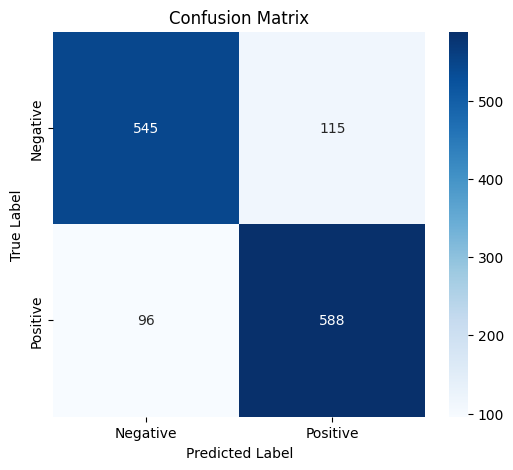

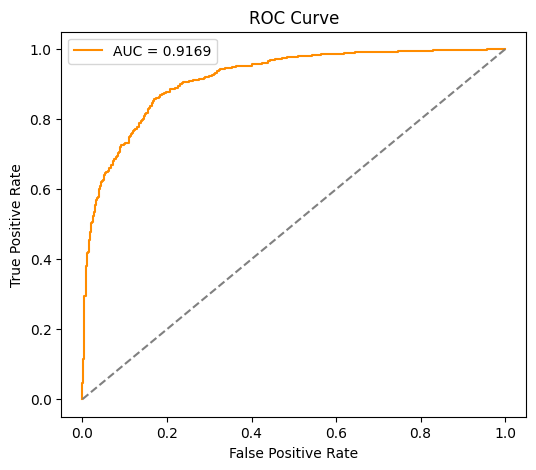


 Ealuating on Test Set:

Confusion Matrix:
[[87 32]
 [12 48]]
Accuracy: 0.7542
Precision: 0.6000
Recall (Sensitivity): 0.8000
Specificity: 0.7311
AUC Score: 0.8335
F1 Score: 0.6857


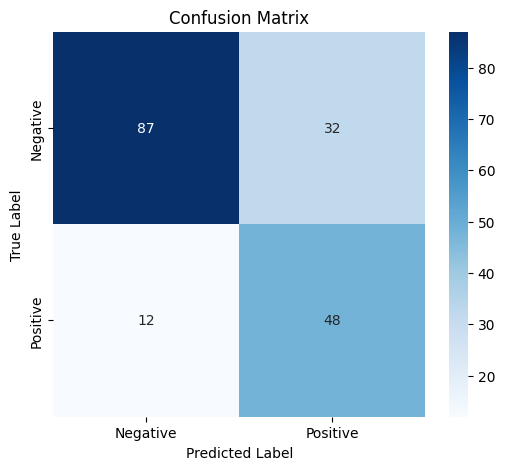

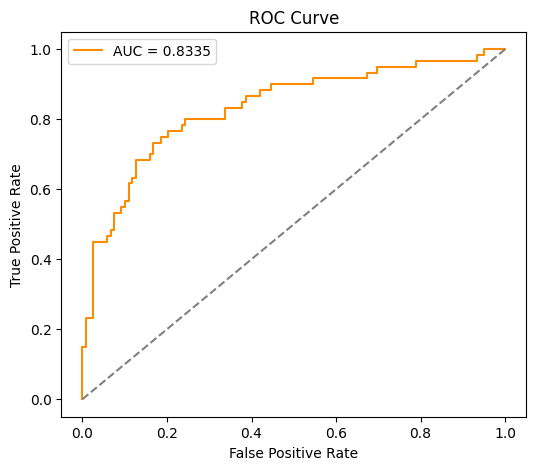

In [12]:
print("\n Evaluating on Validation Set:")
evaluation_list = evaluate_model(model, val_dataloader)
y_true, y_pred_prob, cm, auc_score = evaluation_list[:4]
draw_graph(y_true, y_pred_prob, cm, auc_score)
print("\n Ealuating on Test Set:")
test_evaluation_list = evaluate_model(model, test_dataloader)
t_y_true, t_y_pred_prob, t_cm, t_auc_score = test_evaluation_list[:4]
draw_graph(t_y_true, t_y_pred_prob, t_cm, t_auc_score)

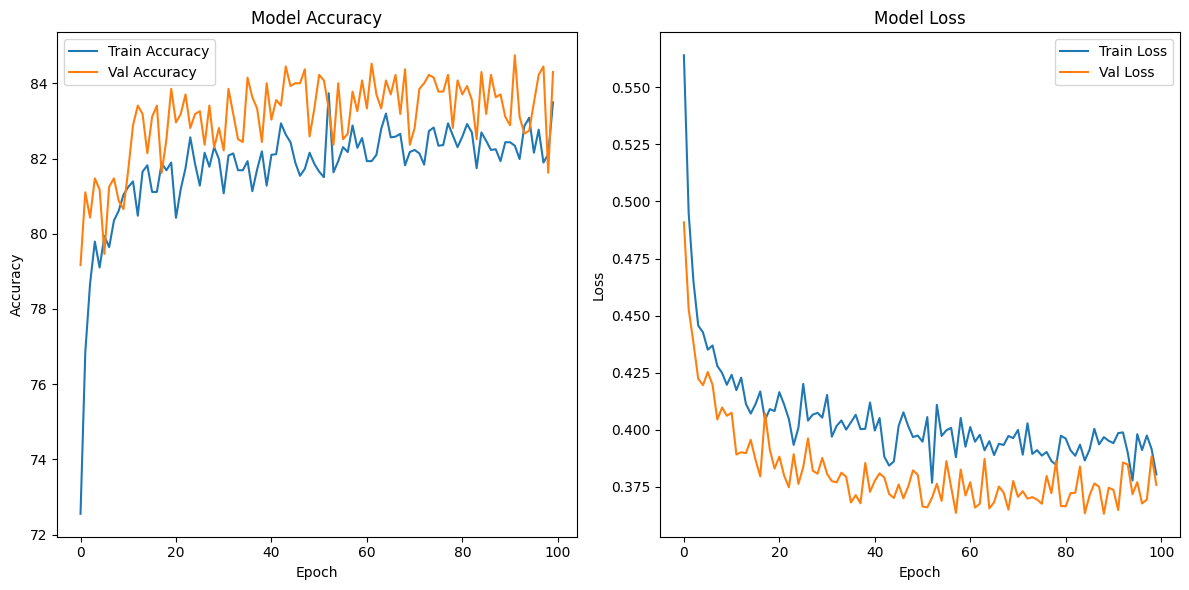

In [13]:
    # Plot Train_Val accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Train_Val loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()